In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [22]:
train = pd.read_csv('titanic.csv')
print(train.shape)
train.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
# 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 결측치 처리
Age, Fare, Cabin column에 결측치가 존재하므로 이를 처리해줘야 한다. 다른 변수들과 달리 Cabin 변수는 문자열 자료형이므로 평균, 중간값 등으로 대체하기에 어려움이 있다. 결측치 처리 방법을 결정하려면 데이터의 분포를 확인해보는 것이 우선이다.

### 1. Age

<AxesSubplot:xlabel='Age', ylabel='Count'>

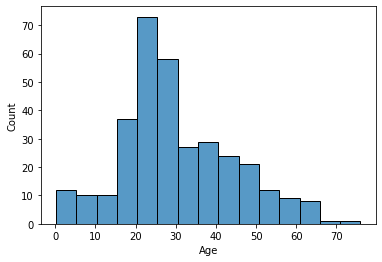

In [13]:
sns.histplot(data=train['Age'])

약 20%에 해당하는 데이터가 결측치로 되어 있으며, 분포를 확인해보니 right-skewed 형태임을 알 수 있다. 정규분포 형태를 보이지 않으므로
평균으로 대체하는 것은 적절하지 않다. 따라서 중간값으로 대체하는 선택을 하였다. 다만 전체 데이터의 중간값으로 대체하기보다는 <b>나이와 상관관계가 큰 변수</b>로 그룹화한 뒤 각 그룹의 나이 중간값으로 대체하는 것이 모델의 성능에 도움이 될 것이다.

In [14]:
train['Age'] = train['Age'].fillna(train['Age'].median())

### 2. Fare
Fare가 결측치인 사람은 1명밖에 없으므로 단순히 drop을 해주었다. 데이터의 수가 418개에서 417개로 줄어들게 된다.

In [17]:
train = train[train['Fare'].notna()]

### 3. Cabin
Cabin feature는 문자열 자료형으로 되어 있기 때문에 평균이나 중간값으로 단순히 대체하기에는 어려움이 있다. 또한 타이타닉호 탑승객의 생존율에 큰 영향을 주는 좌석의 위치를 담고 있는 변수이므로 단순히 무시할 수도 없다. 모델의 성능을 높이려면 타이타닉호의 구조와 좌석의 위치, 좌석의 등급을 모두 고려하여 결측치를 채우는 방법이 가장 이상적이지만 너무 복잡하므로 그냥 drop을 하였다.

In [18]:
train = train.drop(columns = 'Cabin')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  417 non-null    int64  
 1   Pclass       417 non-null    int64  
 2   Name         417 non-null    object 
 3   Sex          417 non-null    object 
 4   Age          417 non-null    float64
 5   SibSp        417 non-null    int64  
 6   Parch        417 non-null    int64  
 7   Ticket       417 non-null    object 
 8   Fare         417 non-null    float64
 9   Embarked     417 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 35.8+ KB


# Feature Split
### 이름
이름은 성별과 결혼 여부를 찾아낼 수 있으므로 중요한 정보가 된다. Regular expression을 통해서 Mr, Mrs, Miss 등의 정보를 뽑아내면 된다.

In [50]:
train['Parsed Name']  = train['Name'].str.extract('([A-Za-z]+)\.', expand=False)
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First Name,Last Name,Parsed Name
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Kelly,James,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Wilkes,James,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Myles,Thomas,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Wirz,Albert,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen,Alexander,Mrs


# Scaling
연속형 feature인 Age를 scaling

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm_scaler = MinMaxScaler()
sd_scaler = StandardScaler()

# MinMax Scaling
mm_scaler = mm_scaler.fit_transform(train['Fare'].values.reshape(-1,1))
train['mm_scaled_Fare'] = mm_scaler

# Standard Scaling
sd_scaler = sd_scaler.fit_transform(train['Fare'].values.reshape(-1,1))
train['sd_scaled_Fare'] = sd_scaler

train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First Name,Last Name,Parsed Name,mm_scaled_Fare,sd_scaled_Fare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Kelly,James,Mr,0.015282,-0.497811
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Wilkes,James,Mrs,0.013663,-0.512660
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Myles,Thomas,Mr,0.018909,-0.464532
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Wirz,Albert,Mr,0.016908,-0.482888
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen,Alexander,Mrs,0.023984,-0.417971


# One-hot encoding
Categorical variable인 'Pclass' feature를 one-hot encoding

One-hot encoding이므로 length가 3인 벡터에서 각 class마다 하나의 element만이 1이 되고 나머지는 0이 된다.
따라서 class 1, 2, 3이 각각 (1, 0, 0), (0, 1, 0), (0, 0, 1)로 인코딩된다. 이를 통해 classification 문제를
해결할 때에 cross entropy 등의 loss를 간단하게 구할 수 있다.

In [53]:
train['Pclass'].value_counts()

pd.get_dummies(train['Pclass'])

,1,2,3
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1
...,...,...,...
413,0,0,1
414,1,0,0
415,0,0,1
416,0,0,1
